In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [2]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
!pip install imutils
from imutils import paths
from sklearn.utils import shuffle

  Using cached imutils-0.5.4-py3-none-any.whl


In [3]:
width,height=224,224

imagePaths = list(paths.list_images(r"C:\Users\SURENDHAN\Desktop\repo\DR-detection\pro\new"))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

(949, 224, 224, 3)
(949, 5)


In [4]:
data = data / 255.0

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (759, 224, 224, 3)
Test images: (190, 224, 224, 3)
Train label: (759, 5)
Test label: (190, 5)


In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_val.shape)
print("Train label:",y_train.shape)
print("Test label:",y_val.shape)

Train images: (607, 224, 224, 3)
Test images: (152, 224, 224, 3)
Train label: (607, 5)
Test label: (152, 5)


In [7]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras import layers

In [8]:
Vgg16 = VGG16(include_top=False, input_shape= (224,224,3)) 

Vgg16.trainable=False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.00001
        return lr
    elif epoch<=30:
        lr=0.00001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [10]:
model = Sequential()
model.add(Vgg16)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(32 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(5 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="categorical_crossentropy" , metrics=["accuracy"] )

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

# Example of a custom metric function for f1 score
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    epsilon = K.epsilon()
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(K.equal(y_true, 1) & K.equal(y_pred, 1), dtype='float32'))
    fp = K.sum(K.cast(K.equal(y_true, 0) & K.equal(y_pred, 1), dtype='float32'))
    fn = K.sum(K.cast(K.equal(y_true, 1) & K.equal(y_pred, 0), dtype='float32'))
    return 2 * tp / (2 * tp + fp + fn + epsilon)

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score, 'Precision', 'Recall', AUC()])

# EarlyStopping callback: monitor validation loss and stop training if no improvement for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_val, y_val), verbose=1, 
                    callbacks=[lr_callback, early_stopping])


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - Precision: 0.2153 - Recall: 0.2561 - accuracy: 0.2231 - auc: 0.5040 - f1_score: 0.2297 - loss: 1.9488 - val_Precision: 0.3846 - val_Recall: 0.0329 - val_accuracy: 0.2961 - val_auc: 0.6431 - val_f1_score: 0.0800 - val_loss: 1.5375 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - Precision: 0.2447 - Recall: 0.3328 - accuracy: 0.2576 - auc: 0.5744 - f1_score: 0.2797 - loss: 1.5913 - val_Precision: 0.3047 - val_Recall: 0.5132 - val_accuracy: 0.4145 - val_auc: 0.6763 - val_f1_score: 0.3828 - val_loss: 1.5183 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - Precision: 0.2486 - Recall: 0.4569 - accuracy: 0.2420 - auc: 0.5856 - f1_score: 0.3224 - loss: 1.5737 - val_Precision: 0.2996 - val_Recall: 0.5066 - val_accuracy: 0.4211 - val_auc: 0.6915 - val_f1_score: 0.3729 - val_loss: 1.4879 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - Precision: 0.2762 

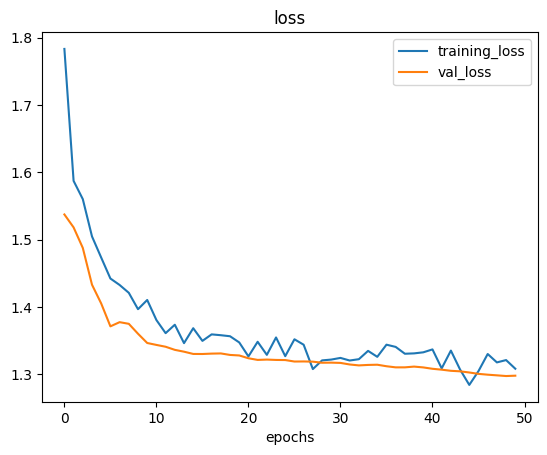

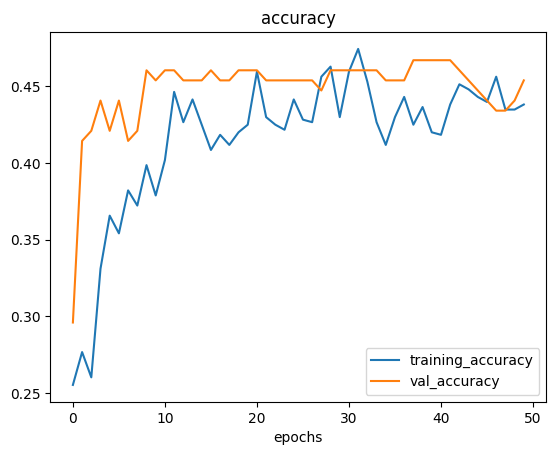

In [12]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()
  
plot_curves(history)

In [13]:
def predict_new(path):
    img = cv2.imread(path)
    predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted: Severe


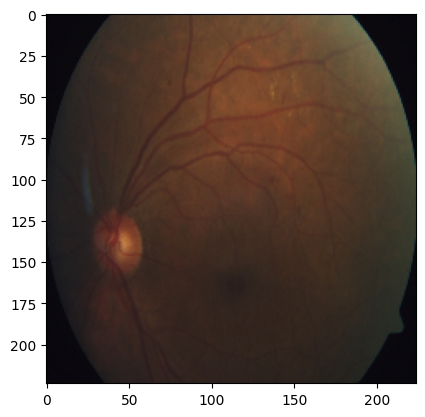

In [16]:
predict_new(r"C:\Users\SURENDHAN\Desktop\repo\DR-detection\pro\new\Mild\4dd9d29eae5d.png")

In [17]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )

In [18]:
test_generator =datagen.flow_from_directory(
    directory=r"C:\Users\SURENDHAN\Desktop\repo\DR-detection\pro\new",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
result=model.evaluate(test_generator)


Found 949 images belonging to 5 classes.


c:\Users\SURENDHAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - Precision: 0.1993 - Recall: 0.3660 - accuracy: 0.2346 - auc: 0.4984 - f1_score: 0.2516 - loss: 1.7187


In [19]:
y_pred = np.argmax(model.predict(test_generator), axis=-1) 
y_true = test_generator.classes 

correct_predictions = np.sum(y_pred == y_true)
total_samples = len(y_true)

print(f"Number of correctly classified samples: {correct_predictions} out of {total_samples}")
print(f"Accuracy (in numbers): {correct_predictions}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
Number of correctly classified samples: 366 out of 949
Accuracy (in numbers): 366


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming result contains [loss, accuracy] and y_true, y_pred are defined
accuracy = result[1]
loss = result[0]

# Calculating Precision, Recall, and F1-Score (weighted average)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Printing the results
print(f"Model accuracy: {accuracy * 100:.2f}%")
print(f"Model loss: {loss * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


Model accuracy: 38.46%
Model loss: 145.36%
Precision: 38.78%
Recall: 38.57%
F1-Score: 33.32%
